In [19]:
## Importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score

In [20]:
## Data Cleaning
sample_data = pd.read_csv('../EXAM/data/cleaned_data.csv',encoding='utf-16')
df = pd.DataFrame(sample_data)

In [21]:
## Dataset split
columns_to_drop = ['price','address','city','type','energy', 'year','area_name', 'age_squared', 'area_code','area_digit_1','area_digit_2','area_digit_3','area_digit_4','area_digit_5','area_digit_6','area_digit_7','area_digit_8','area_digit_9']
X,y = df.drop(columns_to_drop,axis=1),df.price
test_size = 0.30 # taking 70:30 training and test set
seed = 17082023 # Random number seeding for repeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
print(X.columns)

Index(['saledays', 'living_space', 'ground_space', 'rooms', 'owner_expenses',
       'Apartment', 'Holiday home', 'Terraced house', 'Villa', 'land',
       'Energimærke A', 'Energimærke B', 'Energimærke C', 'Energimærke D',
       'Energimærke E', 'Energimærke F', 'Energimærke G', 'age', 'Bornholm',
       'Byen København', 'Fyn', 'Københavns omegn', 'Nordjylland',
       'Nordsjælland', 'Sydjylland', 'Vest- og Sydsjælland', 'Vestjylland',
       'Østjylland', 'Østsjælland'],
      dtype='object')


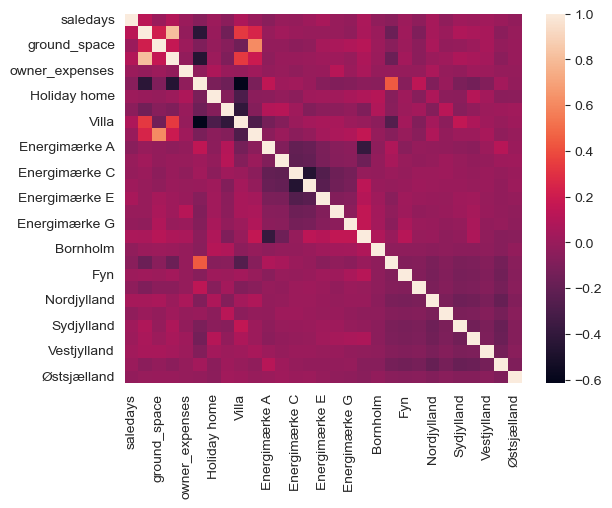

In [22]:
## Heat map
XcorrHeat = sns.heatmap(X.corr())
fig = XcorrHeat.get_figure()
plt.savefig('Xvar_corr_heat_map.png', bbox_inches='tight')

In [25]:
## Main model
param = {
    'learning_rate': 0.01,
    'max_depth': 1
}

gradient_booster = GradientBoostingRegressor(**param)


# Gradient boosting classifiers are required to implement gradient boosting.
gradient_booster.fit(X_train,y_train)
y_test_predict = gradient_booster.predict(X_test)

In [26]:
## R-squared
r2_GBM = r2_score(y_test,y_test_predict)
r2_GBM

0.29232691173447944

In [27]:
## RMSE
RMSE_GBM = mse(y_test,y_test_predict,squared=False)
RMSE_GBM

2624067.3623090107

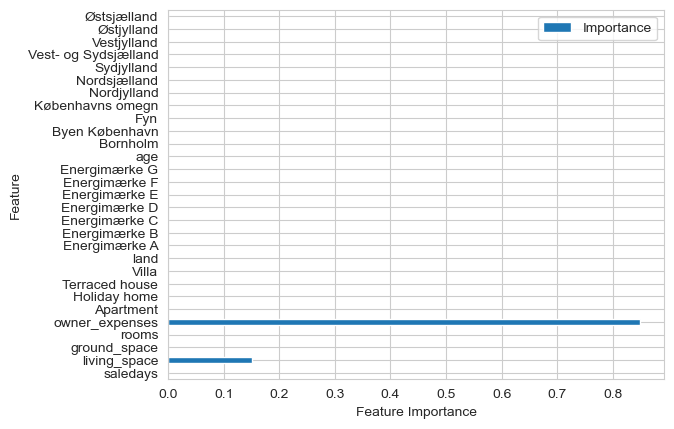

In [28]:
feat_imp_dict = pd.DataFrame([gradient_booster.feature_importances_,X.columns]).T
feat_imp_dict.columns = ['Importance','Feature']
feat_imp_dict = feat_imp_dict.set_index('Feature',drop=True)
feat_imp_dict.plot(kind="barh")
plt.xlabel('Feature Importance')
plt.savefig('GBM_feature_importance-baseline', bbox_inches='tight')

In [40]:
## Define hyperpara
param_grid = {
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.2, 0.3, 0.4, 0.5, 0.6]
}

In [41]:
## 10-fold cross validation
num_folds = 10
kfolds = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

best_score = float('-inf')
best_params = {}

for max_depth in param_grid['max_depth']:
    for learning_rate in param_grid['learning_rate']:
        params = {
            'max_depth': max_depth,
            'learning_rate': learning_rate
        }

        model = GradientBoostingRegressor(**params)
        scores = cross_val_score(model, X_train, y_train, cv=kfolds, scoring='neg_mean_squared_error')
        avg_score = np.mean(scores)

        if avg_score > best_score:
            best_score = avg_score
            best_params = params

print('Best Parameters:', best_params)
print('Best Score:', np.sqrt(-best_score)) # Convert back to positive mean squared error

# Fitting the model with best para
final_model = GradientBoostingRegressor(**best_params)
final_model.fit(X_train, y_train)

y_test_predict = final_model.predict(X_test)

Best Parameters: {'max_depth': 3, 'learning_rate': 0.4}
Best Score: nan


/var/folders/4l/mjqp680s3ld1jxwcfps_43800000gn/T/ipykernel_1229/312534209.py:24: RuntimeWarning: invalid value encountered in sqrt
  print('Best Score:', np.sqrt(best_score)) # Convert back to positive mean squared error


In [42]:
## R-squared
r2_GBM = r2_score(y_test,y_test_predict)
r2_GBM

0.5551389956827988

In [43]:
## RMSE
RMSE_GBM = mse(y_test,y_test_predict,squared=False)
RMSE_GBM

2080514.7945411783

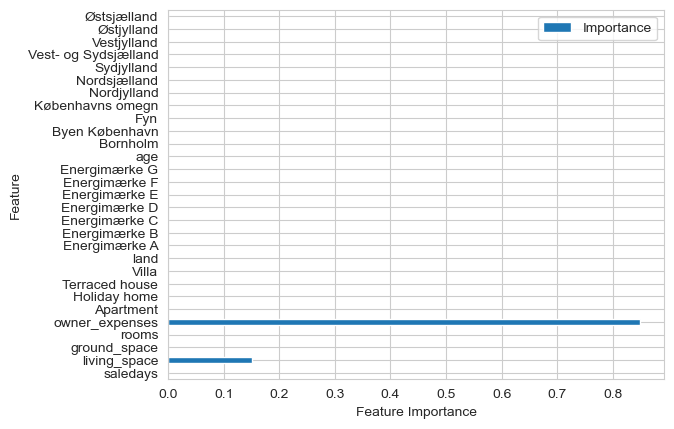

In [44]:
# Feature Importance
feat_imp_dict = pd.DataFrame([gradient_booster.feature_importances_,X.columns]).T
feat_imp_dict.columns = ['Importance','Feature']
feat_imp_dict = feat_imp_dict.set_index('Feature',drop=True)
feat_imp_dict.plot(kind="barh")
plt.xlabel('Feature Importance')
plt.savefig('GBM_feature_importance',bbox_inches='tight')
